## Time Series router traffic forecasting challenge

<h2> Problem statement </h2>

The problem is to forecast the router traffic given its historical data. This is a time series problem as you know. The dataset consists of router traffic data from 1/10/2018 to 2/11/2018 for 5 router/network devices. Our task is to build a model which identifies the patterns of 5 of those network devices and to forecast traffic seperately for the next 2 or 3 days.

This problem was a part of my internship interview at CanGo Networks pvt ltd, Chennai.

<h2>Overview of dataset</h2>

Dataset was given by CanGo Networks pvt ltd. It consists of KPI, ne_date, ne_id, ne_hour, metric and the value. Here value is our predictor variable. There are 5 network devices in the data for which we will have to forecast their value for the next 2 or 3 days. Dataset has 3600 odd records and 6 features

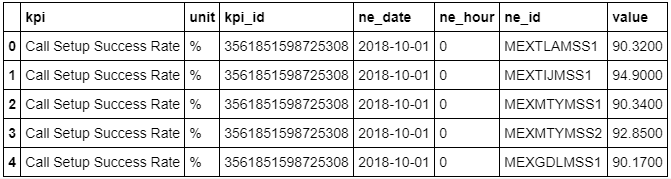

<h2> Techniques I tried</h2>
I started with AR and Arima since we had hourly predictions for a month. But unfortunately, both of these models were not able to capture the dynamics in the data. Hence I posed this as a regression problem, I created some more features and did regression using XGBoost regressor and the results were good!

<h2>Evaluation Criteria</h2>
I used MSE and MAE as metrics for this problem since we are regresing the data

<h2>Resources</h2>
I used kaggle, google and some stackexchanges to get help from as usual

<h2>Author</h2>
Karthikeyan MG

The reason I choose this problem is the data I'm working are from real physical network devices and not some curated data which is clean and neat. And solving this problem has a business impact.

### [1.0] Imports

In [221]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import matplotlib.pyplot as plt
import xgboost as xgb

In [9]:
df = pd.read_csv('Call_Setup_Success_Rate_1month_hourly.csv')

In [10]:
df.shape

(3960, 1)

In [11]:
df.head()

,kpi$unit$kpi_id$ne_date$ne_hour$ne_id$value
0,Call Setup Success Rate$%$3561851598725308$201...
1,Call Setup Success Rate$%$3561851598725308$201...
2,Call Setup Success Rate$%$3561851598725308$201...
3,Call Setup Success Rate$%$3561851598725308$201...
4,Call Setup Success Rate$%$3561851598725308$201...


### [1.1] Data organizer function

Eventhough there are many other simpler methods to organize this data. I tried solving this programatically

In [12]:
def data_corrector(df):
    
    new_df = pd.DataFrame(columns=[i for i in np.squeeze(df.columns.str.split(pat='$'))])
    for i in range(len(df)):
        row_data = list(df.iloc[i].str.split(pat="$"))
        squeezed_row = np.squeeze(row_data)
        new_df = new_df.append(pd.Series(squeezed_row, index=[i for i in np.squeeze(df.columns.str.split(pat='$'))]), ignore_index=True)
    return new_df

In [13]:
new_df = data_corrector(df)

In [14]:
new_df.head()

,kpi,unit,kpi_id,ne_date,ne_hour,ne_id,value
0,Call Setup Success Rate,%,3561851598725308,2018-10-01,0,MEXTLAMSS1,90.3200
1,Call Setup Success Rate,%,3561851598725308,2018-10-01,0,MEXTIJMSS1,94.9000
2,Call Setup Success Rate,%,3561851598725308,2018-10-01,0,MEXMTYMSS1,90.3400
3,Call Setup Success Rate,%,3561851598725308,2018-10-01,0,MEXMTYMSS2,92.8500
4,Call Setup Success Rate,%,3561851598725308,2018-10-01,0,MEXGDLMSS1,90.1700


In [22]:
new_df.to_csv('new_df.csv', index=False)

### [1.2] Change dates to timestamp

In [15]:
def date_converter(date):
    return pd.datetime.strptime(date, '%Y-%m-%d')

In [16]:
new_df = pd.read_csv('new_df.csv', parse_dates=[3], date_parser=date_converter, index_col=[3])

In [17]:
new_df.head()

,kpi,unit,kpi_id,ne_hour,ne_id,value
ne_date,,,,,,
2018-10-01,Call Setup Success Rate,%,3561851598725308,0,MEXTLAMSS1,90.32
2018-10-01,Call Setup Success Rate,%,3561851598725308,0,MEXTIJMSS1,94.90
2018-10-01,Call Setup Success Rate,%,3561851598725308,0,MEXMTYMSS1,90.34
2018-10-01,Call Setup Success Rate,%,3561851598725308,0,MEXMTYMSS2,92.85
2018-10-01,Call Setup Success Rate,%,3561851598725308,0,MEXGDLMSS1,90.17


In [18]:
new_df.shape

(3960, 6)

In [24]:
new_df.to_csv('new_df.csv', index=False)

### [1.3] Simple data cleaning

#### [1.3.1] Checking for duplicates

In [25]:
sum(new_df.duplicated())

0

We will first explore the entire dataset once and after this we will split datapoints based on network devices and will perform a in-depth analysis and prediction on data of each of the network device

Text(0.5,0,'dates')

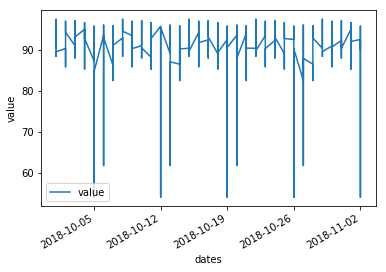

In [31]:
ax = new_df.plot(y='value')
ax.set_ylabel('value')
ax.set_xlabel('dates')

There is no clear trend in the graph, the time series graph of the data and we observe the data is stationary i.e the mean, variance and covariance are equal throughout different time steps. Still we will check using statistical methods to prove it.

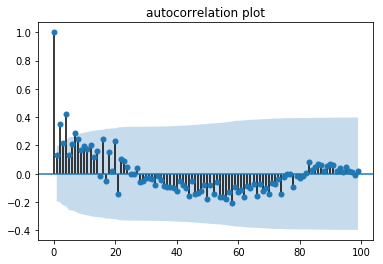

In [27]:
plot_acf(new_df['value'][:100], title='autocorrelation plot');

But the autocorrelation plot shows a little bit of non stationarity in the data

### [1.4] Getting data for each and every network device

In [28]:
split_df = new_df.groupby(by='ne_id')
split_df.describe()

kpi_id                                                       \
            count          mean        std           min           25%   
ne_id                                                                    
MEXGDLMSS1  792.0  3.561852e+15  18.011374  3.561852e+15  3.561852e+15   
MEXMTYMSS1  792.0  3.561852e+15  18.011374  3.561852e+15  3.561852e+15   
MEXMTYMSS2  792.0  3.561852e+15  18.011374  3.561852e+15  3.561852e+15   
MEXTIJMSS1  792.0  3.561852e+15  18.011374  3.561852e+15  3.561852e+15   
MEXTLAMSS1  792.0  3.561852e+15  18.011374  3.561852e+15  3.561852e+15   

                                                     ne_hour        ...    \
                     50%           75%           max   count  mean  ...     
ne_id                                                               ...     
MEXGDLMSS1  3.561852e+15  3.561852e+15  3.561852e+15   792.0  11.5  ...     
MEXMTYMSS1  3.561852e+15  3.561852e+15  3.561852e+15   792.0  11.5  ...     
MEXMTYMSS2  3.561852e+15  3.561852e+15  3.561852e+15   792.0  11.5  ...     
MEXTIJMSS1  3.561852e+15  3.561852e+15  3.561852e+15   792.0  11.5  ...     
MEXTLAMSS1  3.561852e+15  3.561852e+15  3.561852e+15   792.0  11.5  ...     

                         value                                             \
              75%   max  count       mean       std    min    25%     50%   
ne_id                                                                       
MEXGDLMSS1  17.25  23.0  792.0  91.166263  1.918872  77.80  90.45  91.540   
MEXMTYMSS1  17.25  23.0  792.0  89.602803  5.900741  54.03  89.75  91.120   
MEXMTYMSS2  17.25  23.0  792.0  92.566149  2.102929  87.01  91.18  92.680   
MEXTIJMSS1  17.25  23.0  792.0  92.554154  2.033690  86.61  91.24  92.755   
MEXTLAMSS1  17.25  23.0  792.0  91.065051  1.726271  82.48  90.57  91.450   

                          
              75%    max  
ne_id                     
MEXGDLMSS1  92.22  94.11  
MEXMTYMSS1  92.06  94.40  
MEXMTYMSS2  93.96  97.40  
MEXTIJMSS1  94.06  97.05  
MEXTLAMSS1  92.08  93.75  

[5 rows x 24 columns]

There are not a lot of major outliers in the data and the quantiles seem to fine which is a good sign

In [36]:
np.unique(new_df['ne_id'])

array(['MEXGDLMSS1', 'MEXMTYMSS1', 'MEXMTYMSS2', 'MEXTIJMSS1',
       'MEXTLAMSS1'], dtype=object)

 We will segeregate data based on network device id such we can forecast each of our network devices seperately

In [30]:
MEXGDLMSS1_df = new_df[new_df['ne_id'] == 'MEXGDLMSS1']
MEXMTYMSS1_df = new_df[new_df['ne_id'] == 'MEXMTYMSS1']
MEXMTYMSS2_df = new_df[new_df['ne_id'] == 'MEXMTYMSS2']
MEXTIJMSS1_df = new_df[new_df['ne_id'] == 'MEXTIJMSS1']
MEXTLAMSS1_df = new_df[new_df['ne_id'] == 'MEXTLAMSS1']

### [1.5] Lets export all the induvidual datasets

In [ ]:
MEXGDLMSS1_df.to_csv('MEXGDLMSS1_df.csv', index=False)
MEXMTYMSS1_df.to_csv('MEXMTYMSS1_df.csv', index=False)
MEXMTYMSS2_df.to_csv('MEXMTYMSS2_df.csv', index=False)
MEXTIJMSS1_df.to_csv('MEXTIJMSS1_df.csv', index=False)
MEXTLAMSS1_df.to_csv('MEXTLAMSS1_df.csv', index=False)

### [1.6] Working with data

#### [1.6.1]Network device MEXGDLMSS1

Text(0.5,0,'dates')

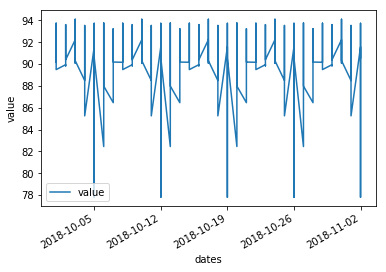

In [32]:
ax = MEXGDLMSS1_df.plot(y='value')
ax.set_ylabel('value')
ax.set_xlabel('dates')

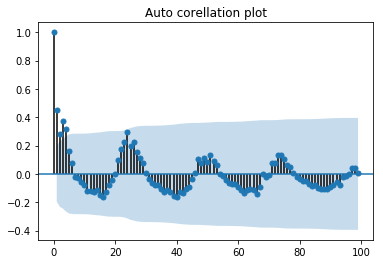

In [55]:
plot_acf(MEXGDLMSS1_df['value'][:100], title='Auto corellation plot');

So its almost stationary i.e mean, variance and covariance at different time intervals are almost equal and hence we can apply time series forecasting models such as ARMA, ARIMA etc etc

Text(0,0.5,'value')

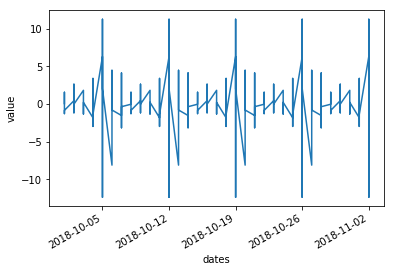

In [36]:
MEXGDLMSS1_df_diff = MEXGDLMSS1_df['value'].diff(periods=1)
ax = MEXGDLMSS1_df_diff.plot(y='value')
ax.set_xlabel('dates')
ax.set_ylabel('value')

In [37]:
MEXGDLMSS1_df_diff = pd.DataFrame(MEXGDLMSS1_df_diff, columns=['date', 'value'])
MEXGDLMSS1_df_diff.drop(columns=['date'], axis=1, inplace=True)

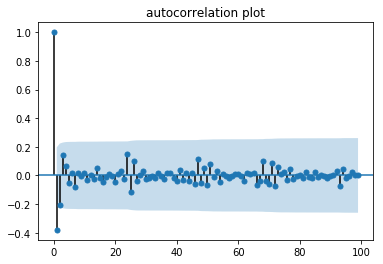

In [38]:
plot_acf(MEXGDLMSS1_df_diff[1:][:100], title='autocorrelation plot');

This signal is more close to being stationary and this is what we want. Now we will figure out whether rest of the network devices have similar behaviour

### [1.7] MEXMTYMSS1_df network device

Text(0,0.5,'values')

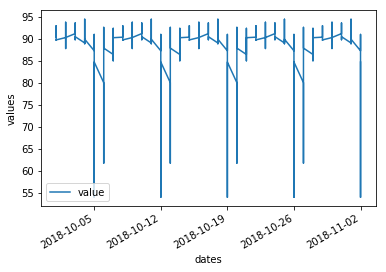

In [40]:
ax = MEXMTYMSS1_df.plot(y='value'[:100])
ax.set_xlabel('dates')
ax.set_ylabel('values')

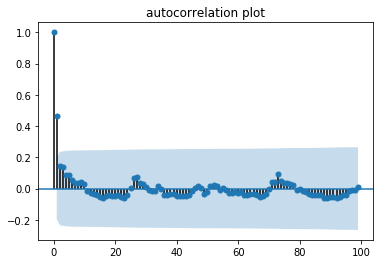

In [42]:
plot_acf(MEXMTYMSS1_df['value'][:100], title='autocorrelation plot');

This is also close to being stationary

Text(0,0.5,'values')

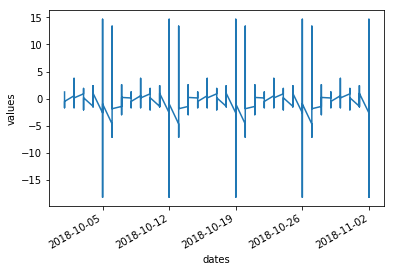

In [43]:
MEXMTYMSS1_df_diff = MEXMTYMSS1_df['value'].diff(periods=1)
ax = MEXMTYMSS1_df_diff.plot(y='value')
ax.set_xlabel('dates')
ax.set_ylabel('values')

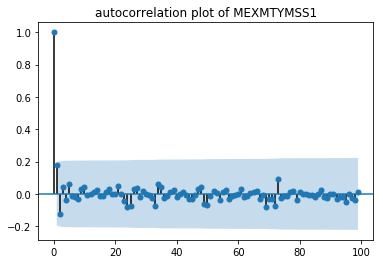

In [45]:
plot_acf(MEXMTYMSS1_df_diff[1:][:100], title='autocorrelation plot of MEXMTYMSS1');

This one looks so close to being perfectly stationary which is good

### MEXMTYMSS2_df network device

Text(0,0.5,'values')

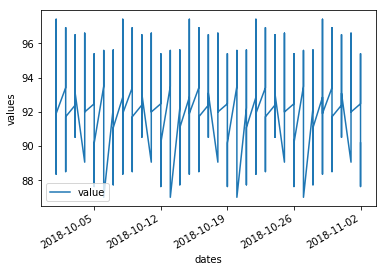

In [46]:
ax = MEXMTYMSS2_df.plot(y='value'[:100])
ax.set_xlabel('dates')
ax.set_ylabel('values')

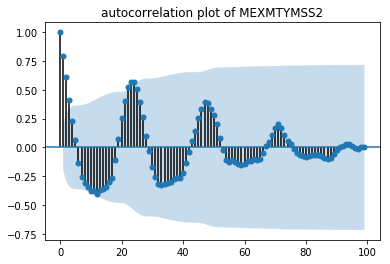

In [48]:
plot_acf(MEXMTYMSS2_df['value'][:100], title='autocorrelation plot of MEXMTYMSS2');

This is not anywhere close to being stationary. So the only way here is to use to autocorrelation stuff

Text(0,0.5,'values')

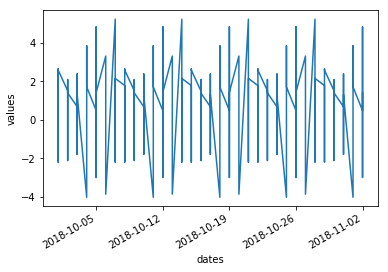

In [50]:
MEXMTYMSS2_df_diff = MEXMTYMSS2_df['value'].diff(periods=1)
ax = MEXMTYMSS2_df_diff.plot(y='value')
ax.set_xlabel('dates')
ax.set_ylabel('values')

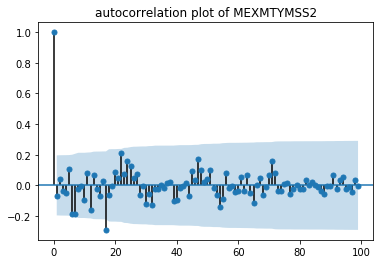

In [51]:
plot_acf(MEXMTYMSS2_df_diff[1:][:100], title='autocorrelation plot of MEXMTYMSS2');

Again looks so close to being perfectly stationary

### MEXTIJMSS1_df network device

Text(0,0.5,'values')

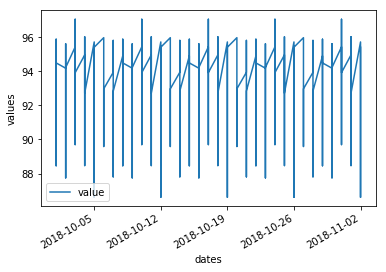

In [52]:
ax = MEXTIJMSS1_df.plot(y='value'[:100])
ax.set_xlabel('dates')
ax.set_ylabel('values')

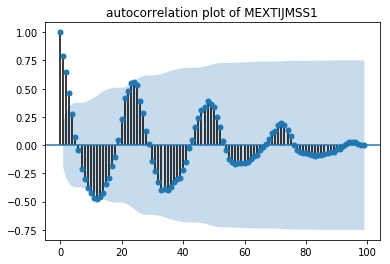

In [56]:
plot_acf(MEXTIJMSS1_df['value'][:100], title='autocorrelation plot of MEXTIJMSS1');

Text(0,0.5,'values')

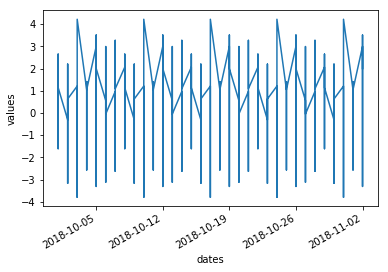

In [57]:
MEXTIJMSS1_df_dff = MEXTIJMSS1_df['value'].diff(periods=1)
ax=MEXTIJMSS1_df_dff.plot(y='value')
ax.set_xlabel('dates')
ax.set_ylabel('values')

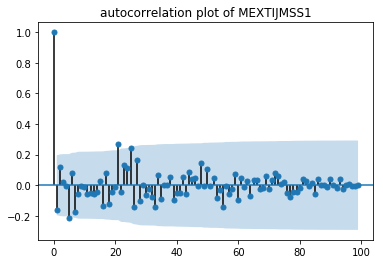

In [59]:
plot_acf(MEXTIJMSS1_df_dff[1:][:100], title='autocorrelation plot of MEXTIJMSS1');

Close to being perfectly stationary

### MEXTLAMSS1_df network device

Text(0,0.5,'values')

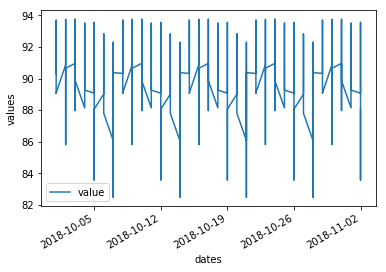

In [60]:
ax=MEXTLAMSS1_df.plot(y='value'[:100])
ax.set_xlabel('dates')
ax.set_ylabel('values')

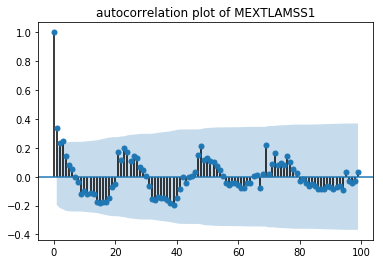

In [61]:
plot_acf(MEXTLAMSS1_df['value'][:100], title='autocorrelation plot of MEXTLAMSS1');

This is also close to being stationary

Text(0,0.5,'values')

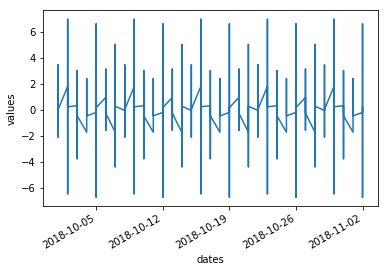

In [62]:
MEXTLAMSS1_df_dff = MEXTLAMSS1_df['value'].diff(periods=1)
ax=MEXTLAMSS1_df_dff.plot(y='value')
ax.set_xlabel('dates')
ax.set_ylabel('values')

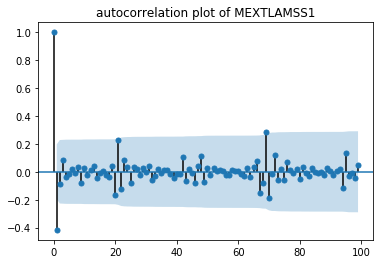

In [64]:
plot_acf(MEXTLAMSS1_df_dff[1:][:100], title='autocorrelation plot of MEXTLAMSS1');

This is perfectly stationary

### [1.7] Modelling

<h4>Network device = MEXGDLMSS1</h4>

Here we are doing time based splitting. i.e we put the oldest 80% data as train and the newest 20% as test as the model is going to predict for future and hence need to be fed with newest data which will closely model the future data

#### [1.7.1] Train test split

In [31]:
MEXGDLMSS1_x_train = MEXGDLMSS1_df[0:int(np.round(0.8*MEXGDLMSS1_df.shape[0]))]
MEXGDLMSS1_x_test = MEXGDLMSS1_df[int(np.round(0.8*MEXGDLMSS1_df.shape[0])):]

In [32]:
print(str(MEXGDLMSS1_x_train.shape) + ' is the size of train data')
print(str(MEXGDLMSS1_x_test.shape) + ' is the size of test data')

(634, 6) is the size of train data
(158, 6) is the size of test data


In [48]:
MEXGDLMSS1_x_train = MEXGDLMSS1_x_train.drop(columns=['kpi', 'unit', 'kpi_id', 'ne_hour', 'ne_id'])

### [1.8] Simple AR Model

In [51]:
model_ar = AR(MEXGDLMSS1_x_train)
model_ar_fit = model_ar.fit()

C:\Users\karth\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [52]:
MEXGDLMSS1_pred = (model_ar_fit.predict(start=634, end=791))

C:\Users\karth\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [53]:
MEXGDLMSS1_pred.values[:10]

array([91.85479013, 92.26073341, 91.7485111 , 91.17972818, 90.77289361,
       91.08951199, 92.18544221, 91.84174396, 91.83301036, 89.77164584])

In [54]:
MEXGDLMSS1_x_test = MEXGDLMSS1_x_test.drop(columns=['kpi', 'unit', 'kpi_id', 'ne_hour', 'ne_id'])

#### [1.8.1] Plots comparing actual and predicted

In [55]:
actual = np.array(MEXGDLMSS1_x_test['value'])
predicted = MEXGDLMSS1_pred.values

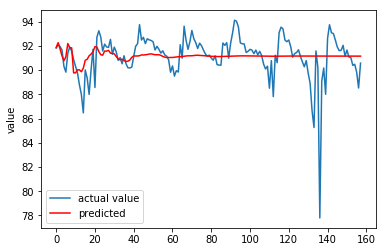

In [59]:
plt.plot(actual, label='actual value')
plt.plot(predicted, color='red', label='predicted')
plt.ylabel('value')
plt.legend()

##### The above graph shows the AR model clearly did not understand our data well. We will try various other models next

### [1.9] ARIMA Model

In [60]:
#The three values are for AR model, Integrated order and moving average values

model_arima = ARIMA(MEXGDLMSS1_x_train, order=(3,1,6))
model_arima_fit = model_arima.fit(start_ar_lags=13)
print('the aic score is ', model_arima_fit.aic)

C:\Users\karth\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\karth\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


the aic score is  2412.0236755722703


In [61]:
MEXGDLMSS1_pred = (model_arima_fit.forecast(steps=158))

In [62]:
predicted = MEXGDLMSS1_pred[0]

### Plots comparing actual and predicted

In [63]:
actual = np.array(MEXGDLMSS1_x_test['value'])
# predicted = MEXGDLMSS1_pred.values

Text(0,0.5,'value')

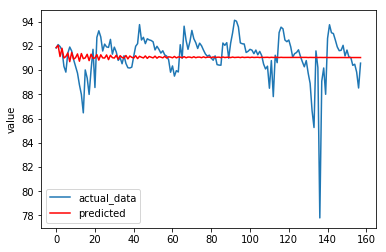

In [66]:
plt.plot(actual, label='actual_data')
plt.plot(predicted, color='red', label='predicted')
plt.legend()
plt.ylabel('value')

##### OK, Even ARIMA was not able to capture the dynamics in the data. Now lets start exploring Machine learning models

### [1.10] Another Simple test for stationarity just to be sure

In [200]:
np.mean(MEXGDLMSS1_df['value'].values)

91.16626262626262

In [201]:
np.mean(MEXGDLMSS1_x_train['value'].values)

91.16900630914826

In [202]:
np.mean(MEXGDLMSS1_x_test['value'].values)

91.15525316455697

In [203]:
from statistics import variance

In [204]:
variance(MEXGDLMSS1_x_train['value'].values)

3.8055186002760877

In [205]:
variance(MEXGDLMSS1_x_test['value'].values)

3.2076454769007507

### [1.11] Machine learning approach

In [68]:
df = pd.read_csv('new_df.csv')

### [1.11.1] XGBoost

#### [1.11.1.1] Lets create features for our data

In [131]:
def date_converter(date):
    return pd.datetime.strptime(date, '%Y-%m-%d')

In [132]:
new_df = pd.read_csv('new_df.csv', parse_dates=[3], date_parser=date_converter, index_col=[3])

In [133]:
##credits: www.kaggle.coms

def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [135]:
xgboost_data = create_features(new_df, label='value')[0]
xgboost_labels = create_features(new_df, label='value')[1]

#hour data from the create_features functions seems to be incorrect. Therefore, we are adding in the original hour values
xgboost_data['hour'] = new_df['ne_hour'].values
xgboost_data['ne_id'] = new_df['ne_id']
xgboost_labels = pd.DataFrame(xgboost_labels, columns=['value'])

In [321]:
xgboost_data.to_csv('xgboost_data.csv', index=False)
xgboost_labels.to_csv('xgboost_labels.csv', index=False)

In [145]:
xgboost_data['labels'] = xgboost_labels

#### [1.11.2] We will split data based on the network device. There are 5 devices and hence we will have 5 datasets

In [147]:
xgboost_MEXGDLMSS1_df = xgboost_data[xgboost_data['ne_id'] == 'MEXGDLMSS1']
xgboost_MEXMTYMSS1_df = xgboost_data[xgboost_data['ne_id'] == 'MEXMTYMSS1']
xgboost_MEXMTYMSS2_df = xgboost_data[xgboost_data['ne_id'] == 'MEXMTYMSS2']
xgboost_MEXTIJMSS1_df = xgboost_data[xgboost_data['ne_id'] == 'MEXTIJMSS1']
xgboost_MEXTLAMSS1_df = xgboost_data[xgboost_data['ne_id'] == 'MEXTLAMSS1']

#### [1.11.3] Lets export all the induvidual datasets

In [349]:
xgboost_MEXGDLMSS1_df.to_csv('xgboost_MEXGDLMSS1_df.csv', index=False)
xgboost_MEXMTYMSS1_df.to_csv('xgboost_MEXMTYMSS1_df.csv', index=False)
xgboost_MEXMTYMSS2_df.to_csv('xgboost_MEXMTYMSS2_df.csv', index=False)
xgboost_MEXTIJMSS1_df.to_csv('xgboost_MEXTIJMSS1_df.csv', index=False)
xgboost_MEXTLAMSS1_df.to_csv('xgboost_MEXTLAMSS1_df.csv', index=False)

#### [1.11.4] Lets start modelling

For each network device's data we are splitting data as train and test. Since the data is already present in ascending date wise, We will take first 80% data as train and last 20% data as split

In [200]:
xgboost_MEXGDLMSS1_train = xgboost_MEXGDLMSS1_df[0:int(np.round(0.8*xgboost_MEXGDLMSS1_df.shape[0]))]
xgboost_MEXGDLMSS1_test = xgboost_MEXGDLMSS1_df[int(np.round(0.8*xgboost_MEXGDLMSS1_df.shape[0])):]

train_labels = xgboost_MEXGDLMSS1_train['labels']
test_labels = xgboost_MEXGDLMSS1_test['labels']

xgboost_MEXGDLMSS1_train = xgboost_MEXGDLMSS1_train.drop(columns=['ne_id', 'labels'])
xgboost_MEXGDLMSS1_test = xgboost_MEXGDLMSS1_test.drop(columns=['ne_id', 'labels'])

#### [1.11.4] Run the model

In [214]:
reg = xgb.XGBRegressor(n_estimators=50)

reg.fit(xgboost_MEXGDLMSS1_train, train_labels)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

#### [1.11.5] Feature importance plots

These plots are very helpful as they convey which features are very important for prediction. From the below plot we understand that hour and dayofweek features have high FScore which means that hour and dayofweek are the most important value when the algorithm forecasts the predictor value

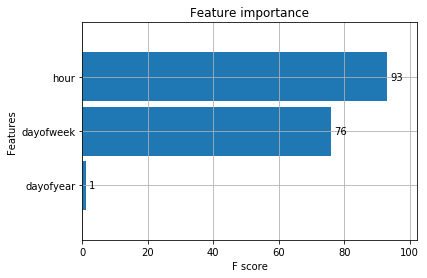

In [210]:
xgb.plot_importance(reg, height=0.9)

#### [1.11.6] prediction

In [211]:
pred = reg.predict(xgboost_MEXGDLMSS1_test)

#### [1.11.7] plots

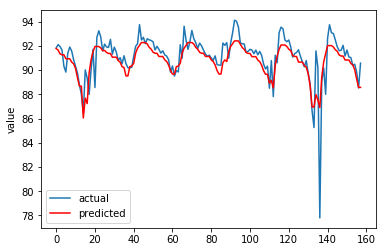

In [212]:
plt.plot(test_labels.values, label='actual')
plt.plot(pred, color='red', label='predicted')
plt.ylabel('value')
plt.legend()

#### [1.11.8] metrics

In [219]:
print(mean_squared_error(test_labels.values, pred), ' is our mean squared error')

1.3950209035836778  is our mean squared error


In [222]:
print(mean_absolute_error(test_labels.values, pred), ' is our mean absolute error')

0.7408648585066012  is our mean absolute error


### [1.12] Forecasting for unseen unknown data

##### [1.12.1] Here the last day in our test data is 02/11/2018 and so we will predict from 03/11/2018

#### Creates dates

In [223]:
import datetime
dt = datetime.datetime(2018, 11, 3)
end = datetime.datetime(2018, 11, 6, 23, 59, 59)
step = datetime.timedelta(seconds=3600)

result = []

while dt < end:
    result.append(dt.strftime('%Y-%m-%d'))
    dt += step

In [224]:
forecast_df = pd.DataFrame(data=[date_converter(i) for i in result], columns=['ne_date'])

In [225]:
#sanity check
Counter(forecast_df['ne_date'])

Counter({Timestamp('2018-11-03 00:00:00'): 24,
         Timestamp('2018-11-04 00:00:00'): 24,
         Timestamp('2018-11-05 00:00:00'): 24,
         Timestamp('2018-11-06 00:00:00'): 24})

In [226]:
forecast_df = forecast_df.set_index(['ne_date'])

In [227]:
def date_converter(date):
    return pd.datetime.strptime(date, '%Y-%m-%d')

In [228]:
def new_create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [229]:
forecast_df = new_create_features(forecast_df, label=None)
forecast_df['hour'] = (xgboost_MEXGDLMSS1_df['hour'].values[:96])

In [230]:
forecast_df.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
ne_date,,,,,,,,
2018-11-03,0,5,4,11,2018,307,3,44
2018-11-03,1,5,4,11,2018,307,3,44
2018-11-03,2,5,4,11,2018,307,3,44
2018-11-03,3,5,4,11,2018,307,3,44
2018-11-03,4,5,4,11,2018,307,3,44


### So lets now predict for the next 3 days 3/11/2018 to 6/11/2018

In [231]:
pred = reg.predict(forecast_df)

In [232]:
test_values = list(test_labels.values)
forecasted_values = list(pred)

print(len(test_values))
print(len(forecasted_values))

158
96


In [233]:
test_and_forecasted = test_values + forecasted_values

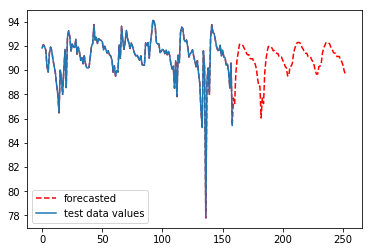

In [508]:
fig, ax = plt.subplots()
ax.plot(test_and_forecasted, 'r--',label='forecasted')
ax.plot(test_and_forecasted[0:159], label='test data values', )
plt.legend()

#### Results

As we see the above results, We understand our model is performing better than the previously seen models without any hyperparameter tuning. Hence if we tune the model well, this should perform very well.

### Now we will do the same for all the other network devices

### Now for the next network device - MEXMTYMSS1

In [235]:
xgboost_MEXMTYMSS1_train = xgboost_MEXMTYMSS1_df[0:int(np.round(0.8*xgboost_MEXMTYMSS1_df.shape[0]))]
xgboost_MEXMTYMSS1_test = xgboost_MEXMTYMSS1_df[int(np.round(0.8*xgboost_MEXMTYMSS1_df.shape[0])):]
train_labels = xgboost_MEXMTYMSS1_train['labels']
test_labels = xgboost_MEXMTYMSS1_test['labels']
xgboost_MEXMTYMSS1_train = xgboost_MEXMTYMSS1_train.drop(columns=['ne_id', 'labels'])
xgboost_MEXMTYMSS1_test = xgboost_MEXMTYMSS1_test.drop(columns=['ne_id', 'labels'])

### checking shapes

In [236]:
reg = xgb.XGBRegressor(n_estimators=50)
reg.fit(xgboost_MEXMTYMSS1_train, train_labels)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

##### These plots are very helpful as they convey which features are very important for prediction. From the below plot we understand that hour and dayofweek features have high FScore which means that hour and dayofweek are the most important value when the algorithm forecasts the predictor value

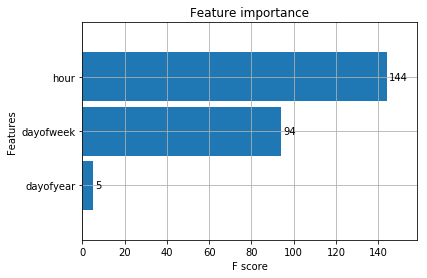

In [238]:
xgb.plot_importance(reg, height=0.9)

### prediction

In [239]:
pred = reg.predict(xgboost_MEXMTYMSS1_test)

### plots on test data

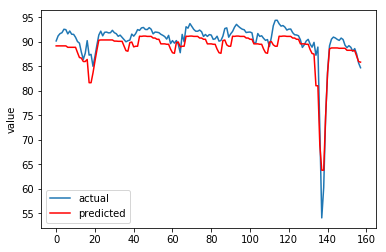

In [240]:
plt.plot(test_labels.values, label='actual')
plt.plot(pred, color='red', label='predicted')
plt.ylabel('value')
plt.legend()

### metrics

In [243]:
print(mean_squared_error(test_labels.values, pred), ' is our mean squared error')

5.078298504704865  is our mean squared error


In [244]:
print(mean_absolute_error(test_labels.values, pred),  ' is our mean absolute error')

1.8163311960727353  is our mean absolute error


### So lets now predict for the next 3 days 3/11/2018 to 6/11/2018

In [245]:
pred = reg.predict(forecast_df)

In [247]:
test_values = list(test_labels.values)
forecasted_values = list(pred)

In [533]:
test_and_forecasted = test_values + forecasted_values

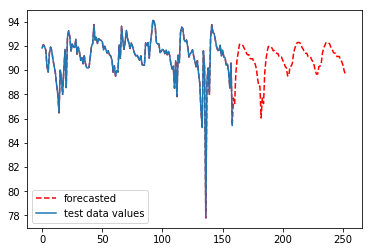

In [248]:
fig, ax = plt.subplots()
ax.plot(test_and_forecasted, 'r--',label='forecasted')
ax.plot(test_and_forecasted[0:159], label='test data values', )
plt.legend()

### Now for the next network device - MEXMTYMSS2

### modelling


In [249]:
xgboost_MEXMTYMSS2_train = xgboost_MEXMTYMSS2_df[0:int(np.round(0.8*xgboost_MEXMTYMSS2_df.shape[0]))]
xgboost_MEXMTYMSS2_test = xgboost_MEXMTYMSS2_df[int(np.round(0.8*xgboost_MEXMTYMSS2_df.shape[0])):]
train_labels = xgboost_MEXMTYMSS2_train['labels']
test_labels = xgboost_MEXMTYMSS2_test['labels']
xgboost_MEXMTYMSS2_train = xgboost_MEXMTYMSS2_train.drop(columns=['labels', 'ne_id'])
xgboost_MEXMTYMSS2_test = xgboost_MEXMTYMSS2_test.drop(columns=['labels', 'ne_id'])

In [250]:
reg = xgb.XGBRegressor(n_estimators=50)
reg.fit(xgboost_MEXMTYMSS2_train, train_labels)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

##### These plots are very helpful as they convey which features are very important for prediction. From the below plot we understand that hour and dayofweek features have high FScore which means that hour and dayofweek are the most important value when the algorithm forecasts the predictor value

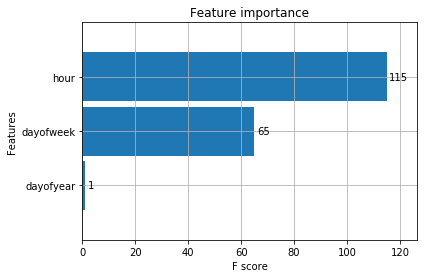

In [252]:
xgb.plot_importance(reg, height=0.9)

### prediction

In [253]:
pred = reg.predict(xgboost_MEXMTYMSS2_test)

### plots on test data

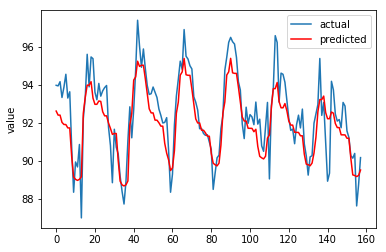

In [254]:
plt.plot(test_labels.values, label='actual')
plt.plot(pred, color='red', label='predicted')
plt.ylabel('value')
plt.legend()

### metrics

In [256]:
print(mean_squared_error(test_labels.values, pred), ' is our mean squared error')

1.3493126710692576  is our mean squared error


In [257]:
print(mean_absolute_error(test_labels.values, pred), ' is our mean absolute error')

0.9400626267058939  is our mean absolute error


### So lets now predict for the next 3 days 3/11/2018 to 6/11/2018

In [258]:
pred = reg.predict(forecast_df)

In [259]:
test_values = list(test_labels.values)
forecasted_values = list(pred)

In [260]:
test_and_forecasted = test_values + forecasted_values

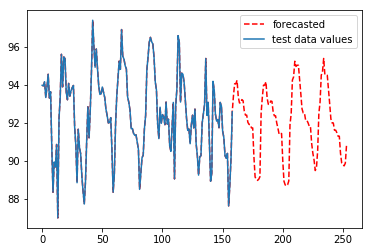

In [261]:
fig, ax = plt.subplots()
ax.plot(test_and_forecasted, 'r--',label='forecasted')
ax.plot(test_and_forecasted[0:159], label='test data values', )
plt.legend()

### Now for the next network device - MEXTIJMSS1

### modelling


In [262]:
xgboost_MEXTIJMSS1_train = xgboost_MEXTIJMSS1_df[0:int(np.round(0.8*xgboost_MEXTIJMSS1_df.shape[0]))]
xgboost_MEXTIJMSS1_test = xgboost_MEXTIJMSS1_df[int(np.round(0.8*xgboost_MEXTIJMSS1_df.shape[0])):]
train_labels = xgboost_MEXTIJMSS1_train['labels']
test_labels = xgboost_MEXTIJMSS1_test['labels']
xgboost_MEXTIJMSS1_train = xgboost_MEXTIJMSS1_train.drop(columns=['ne_id','labels'])
xgboost_MEXTIJMSS1_test = xgboost_MEXTIJMSS1_test.drop(columns=['ne_id','labels'])

In [263]:
reg = xgb.XGBRegressor(n_estimators=50)
reg.fit(xgboost_MEXTIJMSS1_train, train_labels)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

##### These plots are very helpful as they convey which features are very important for prediction. From the below plot we understand that hour and dayofweek features have high FScore which means that hour and dayofweek are the most important value when the algorithm forecasts the predictor value

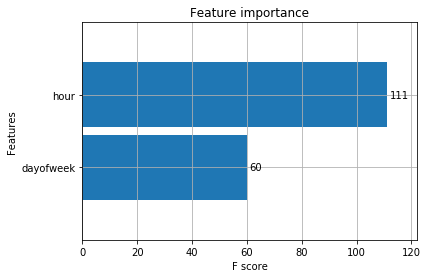

In [264]:
xgb.plot_importance(reg, height=0.9)

### prediction

In [265]:
pred = reg.predict(xgboost_MEXTIJMSS1_test)

### plots on test data

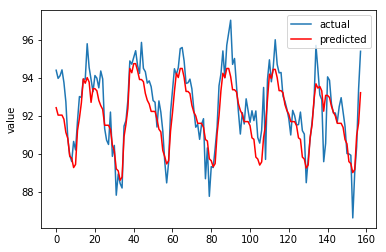

In [266]:
plt.plot(test_labels.values, label='actual')
plt.plot(pred, color='red', label='predicted')
plt.ylabel('value')
plt.legend()

### metrics

In [267]:
print(mean_squared_error(test_labels.values, pred), ' is our mean squared error')

1.192999459932552  is our mean squared error


In [268]:
print(mean_absolute_error(test_labels.values, pred), ' is mean absolute error')

0.8584582152547714  is mean absolute error


### So lets now predict for the next 3 days 3/11/2018 to 6/11/2018

In [269]:
pred = reg.predict(forecast_df)

In [270]:
test_values = list(test_labels.values)
forecasted_values = list(pred)

In [578]:
test_and_forecasted = test_values + forecasted_values

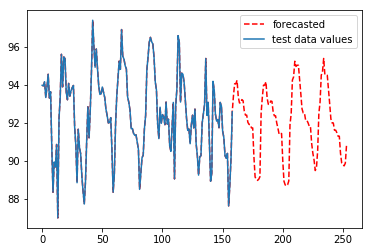

In [271]:
fig, ax = plt.subplots()
ax.plot(test_and_forecasted, 'r--',label='forecasted')
ax.plot(test_and_forecasted[0:159], label='test data values', )
plt.legend()

### Now for the next network device

### Now for the next network device - MEXTLAMSS1

### modelling


In [272]:
xgboost_MEXTLAMSS1_train = xgboost_MEXTLAMSS1_df[0:int(np.round(0.8*xgboost_MEXTLAMSS1_df.shape[0]))]
xgboost_MEXTLAMSS1_test = xgboost_MEXTLAMSS1_df[int(np.round(0.8*xgboost_MEXTLAMSS1_df.shape[0])):]
train_labels = xgboost_MEXTLAMSS1_train['labels']
test_labels = xgboost_MEXTLAMSS1_test['labels']
xgboost_MEXTLAMSS1_train = xgboost_MEXTLAMSS1_train.drop(columns=['ne_id','labels'])
xgboost_MEXTLAMSS1_test = xgboost_MEXTLAMSS1_test.drop(columns=['ne_id','labels'])

In [273]:
reg = xgb.XGBRegressor(n_estimators=50)
reg.fit(xgboost_MEXTLAMSS1_train, train_labels)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

##### These plots are very helpful as they convey which features are very important for prediction. From the below plot we understand that hour and dayofweek features have high FScore which means that hour and dayofweek are the most important value when the algorithm forecasts the predictor value

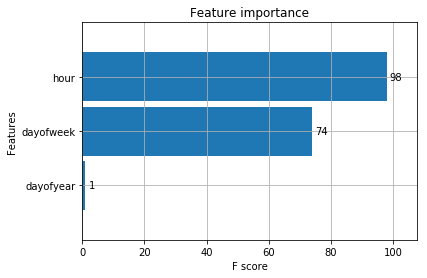

In [274]:
xgb.plot_importance(reg, height=0.9)

### prediction

In [275]:
pred = reg.predict(xgboost_MEXTLAMSS1_test)

### plots on test data

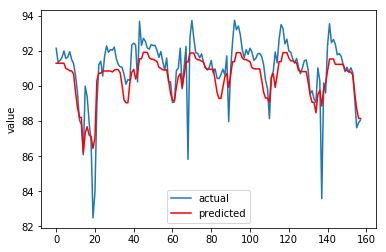

In [276]:
plt.plot(test_labels.values, label='actual')
plt.plot(pred, color='red', label='predicted')
plt.ylabel('value')
plt.legend()

### metrics

In [277]:
print(mean_squared_error(test_labels.values, pred), ' is our mean squared error')

1.344164337904645  is our mean squared error


In [278]:
print(mean_absolute_error(test_labels.values, pred), ' is our mean absolute error')

0.823427440788172  is our mean absolute error


### So lets now predict for the next 3 days 3/11/2018 to 6/11/2018

In [279]:
pred = reg.predict(forecast_df)

In [280]:
test_values = list(test_labels.values)
forecasted_values = list(pred)

In [281]:
test_and_forecasted = test_values + forecasted_values

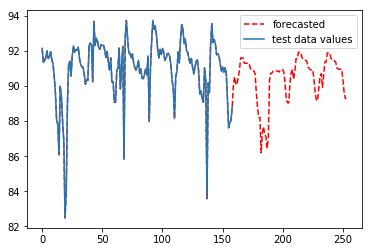

In [282]:
fig, ax = plt.subplots()
ax.plot(test_and_forecasted, 'r--',label='forecasted')
ax.plot(test_and_forecasted[0:159], label='test data values', )
plt.legend()

### Now for the next network device - MEXTLAMSS1

### modelling


In [283]:
xgboost_MEXTLAMSS1_train = xgboost_MEXTLAMSS1_df[0:int(np.round(0.8*xgboost_MEXTLAMSS1_df.shape[0]))]
xgboost_MEXTLAMSS1_test = xgboost_MEXTLAMSS1_df[int(np.round(0.8*xgboost_MEXTLAMSS1_df.shape[0])):]
train_labels = xgboost_MEXTLAMSS1_train['labels']
test_labels = xgboost_MEXTLAMSS1_test['labels']
xgboost_MEXTLAMSS1_train = xgboost_MEXTLAMSS1_train.drop(columns=['ne_id','labels'])
xgboost_MEXTLAMSS1_test = xgboost_MEXTLAMSS1_test.drop(columns=['ne_id','labels'])

In [284]:
reg = xgb.XGBRegressor(n_estimators=50)
reg.fit(xgboost_MEXTLAMSS1_train, train_labels)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

##### These plots are very helpful as they convey which features are very important for prediction. From the below plot we understand that hour and dayofweek features have high FScore which means that hour and dayofweek are the most important value when the algorithm forecasts the predictor value

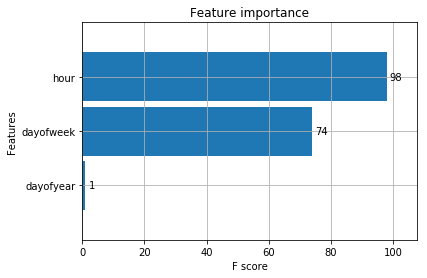

In [285]:
xgb.plot_importance(reg, height=0.9)

### prediction

In [286]:
pred = reg.predict(xgboost_MEXTLAMSS1_test)

### plots

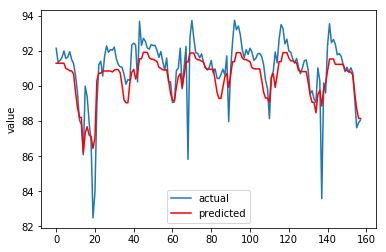

In [287]:
plt.plot(test_labels.values, label='actual')
plt.plot(pred, color='red', label='predicted')
plt.ylabel('value')
plt.legend()

### metrics

In [288]:
print(mean_squared_error(test_labels.values, pred), ' is our mean squared error')

1.344164337904645  is our mean squared error


In [289]:
print(mean_absolute_error(test_labels.values, pred), ' is our mean absolute error')

0.823427440788172  is our mean absolute error


### So lets now predict for the next 3 days 3/11/2018 to 6/11/2018

In [290]:
pred = reg.predict(forecast_df)

In [292]:
test_values = list(test_labels.values)
forecasted_values = list(pred)

In [293]:
test_and_forecasted = test_values + forecasted_values

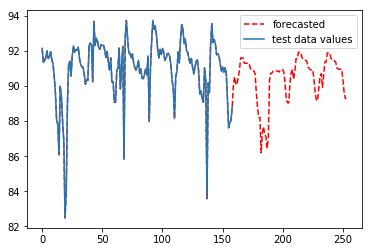

In [294]:
fig, ax = plt.subplots()
ax.plot(test_and_forecasted, 'r--',label='forecasted')
ax.plot(test_and_forecasted[0:159], label='test data values', )
plt.legend()

#### Therefore, we have forecasted the value feature for all the 5 network devices for the next 2-3 days with a good accuracy which can be further improved

### Results and discussions

The above is the detailed report of all the methods/algorithms I used to solve the problem of forecasting the value column for the next two days. Since this is a time series data, my first approach was to use statistical models such as AR, ARIMA etc. After trying with both of them, I got to know that their results were bad by their prediction plots of the test data. Next I tried non linear models that use decision trees as based learners. Decision trees are a tree based algorithm which splits the tree based on the amount of entropy reduced or amount of information gained by a feature. Random forests regressor and XGBoost are advanced versions of Decision tree as they contain lot of decision trees(n_estimators is a hyperparameter and needs to be tuned). After starting to use non linear models, the predictions became good and hence we solved this problem using XGBoost regressor

<h4>Which metrics did I use?</h4>
Since what we are solving is a regression problem, I used mean absolute error and mean squared error as my error metric to express the results as other commonly used metrics such as accuracy, precision, recall are classification metrics and will not work with regression.


<h4>Why did I choose XGBoost regressor?</h4>
XGBoost regressor aka boosting is a form of Gradient boosted decision trees from sklearn. It generally performs better on all kind of problem equal to standard linear models if not better. It's very effective for this kind of time series prediction problem because every set of inputs are row sampled with replacement and column sampled without replacement. This method of feeding in input creates better generalization of model to our data and moreover our model is trained on difference between actual valuse and predicted values during training which is very similar to moving averages model but in a better manner. Decision trees are the base learners in XGBoost with shallow depth and so they start with high bias, low variance and end up having reduced bias,low variance. Considering all the above positive facts about the model, I chose XGBoost regressor to solve this problem

<h4>Forecast plots</h4>
All my forecast plots have been plotted along with history on the XGBoost predicition for each of the network device above as you may have noticed


<h4>Note:</h4>
The code I have written above can be further optimized and repetability can be removed for better performance. The plots I had use here are simple and can be improved to better suit our needs if needed in future

#####                                                 ********THE END********